In [1]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform

%matplotlib inline

In [2]:
import pyspark
sc = pyspark.SparkContext('local[*]')
spark = pyspark.sql.SparkSession(sc)

In [3]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.83909959, -2.70697706, -2.57485453, -2.442732  , -2.31060948,
        -2.17848695, -2.04636442, -1.91424189, -1.78211936, -1.64999683,
        -1.5178743 , -1.38575177, -1.25362924, -1.12150671, -0.98938418,
        -0.85726165, -0.72513912, -0.59301659, -0.46089406, -0.32877153,
        -0.196649  , -0.06452647,  0.06759606,  0.19971858,  0.33184111,
         0.46396364,  0.59608617,  0.7282087 ,  0.86033123,  0.99245376,
         1.12457629,  1.25669882,  1.38882135,  1.52094388,  1.65306641,
         1.78518894,  1.91731147,  2.049434  ,  2.18155653,  2.31367906,
         2.44580159,  2.57792411,  2.71004664,  2.84216917,  2.9742917 ,
         3.10641423,  3.23853676,  3.37065929,  3.50278182,  3.63490435,
         3.76702688])

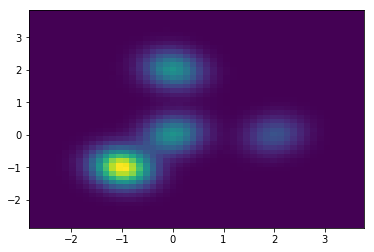

In [4]:
plt.hist2d(data[:,0], data[:,1], bins=50)

In [10]:
class VariationalAutoEncoder(object):
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units,
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0,
                 distribution='normal', serial_layering=None):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.distribution = distribution
        if serial_layering:
            if not isinstance(serial_layering, (list, tuple)):
                raise TypeError("Argument 'serial_layering' must be a list or tuple of integers.")
            elif not all([isinstance(x, int) for x in serial_layering]):
                raise TypeError("Argument 'serial_layering' must be a list or tuple of integers.")
            elif sum(serial_layering) != self.n_hidden_layers:
                raise ValueError("Groupings in 'serial_layering' must sum to 'n_hidden_layers'.")
        self.serial_layering = serial_layering or [self.n_hidden_layers]
        self.layer_sequence = [sum(self.serial_layering[:i + 1]) for i in range(len(self.serial_layering))]

    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, distribution, initialize_layers=None):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            self.distribution = distribution
            self.initialize_layers = initialize_layers or []

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            if self.initialize_layers:
                kernel_initializer, bias_initializer = self.initialize_layers.pop(0)
            else:
                kernel_initializer, bias_initializer = None, None

            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid,
                                                      kernel_initializer=kernel_initializer,
                                                      bias_initializer=bias_initializer))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_mu(self, inputs):
            if self.distribution == 'normal':
                self.mu = tf.layers.Dense(units=self.n_latent_units)
            elif self.distribution == 'vmf':
                self.mu = tf.layers.Dense(units=self.n_latent_units + 1,
                                          activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
            else:
                raise NotImplemented

            self.applied_mu = self.mu.apply(inputs)
            return self.applied_mu

        def add_sigma(self, inputs):
            if self.distribution == 'normal':
                self.sigma = tf.layers.Dense(units=self.n_latent_units)
                self.applied_sigma = self.sigma.apply(inputs)
            elif self.distribution == 'vmf':
                self.sigma = tf.layers.Dense(units=1, activation=tf.nn.softplus)
                self.applied_sigma = self.sigma.apply(inputs) + 1
            else:
                raise NotImplemented
            return self.applied_sigma

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            mu = self.add_mu(layer)
            sigma = self.add_sigma(layer)

            return mu, sigma

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            mu = sess.run([self.mu.kernel, self.mu.bias])

            sigma = sess.run([self.sigma.kernel, self.sigma.bias])

            return layers, mu, sigma

    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units, initialize_layers=None):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units
            self.initialize_layers = initialize_layers or None

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            if self.initialize_layers:
                kernel_initializer, bias_initializer = self.initialize_layers.pop(0)
            else:
                kernel_initializer, bias_initializer = None, None

            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid,
                                                      kernel_initializer=kernel_initializer,
                                                      bias_initializer=bias_initializer))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_output(self, inputs):
            self.output = tf.layers.Dense(units=self.n_output_units)
            self.applied_output = self.output.apply(inputs)
            return self.applied_output

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            output = self.add_output(layer)

            return output

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            output = sess.run([self.output.kernel, self.output.bias])

            return layers, output

    def sampled_z(self, mu, sigma, batch_size):
        if self.distribution == 'normal':
            epsilon = tf.random_normal(tf.stack([int(batch_size), self.n_latent_units]))
            z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
            loss = tf.reduce_mean(-0.5 * self.beta * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1))
        elif self.distribution == 'vmf':
            self.q_z = VonMisesFisher(mu, sigma, validate_args=True, allow_nan_stats=False)
            z = self.q_z.sample()
            self.p_z = HypersphericalUniform(self.n_latent_units, validate_args=True, allow_nan_stats=False)
            loss = tf.reduce_mean(-self.q_z.kl_divergence(self.p_z))
        else:
            raise NotImplemented

        return z, loss

    def build_feature_loss(self, x, output):
        return tf.reduce_mean(tf.reduce_sum(tf.squared_difference(x, output), 1))
    
    def build_encoder_initializers(self, sess, n_hidden_layers):
        return self.build_initializers('encoder', sess, n_hidden_layers)
    
    def build_decoder_initializers(self, sess, n_hidden_layers):
        return self.build_initializers('decoder', sess, n_hidden_layers)

    def build_initializers(self, attr_name, sess, n_hidden_layers):
        if hasattr(self, attr_name):
            layers = getattr(self, attr_name).eval(sess)[0]
            result = []
            for i in range(n_hidden_layers):
                if layers:
                    kernel, bias = layers.pop(0)
                    result.append((tf.constant_initializer(kernel), tf.constant_initializer(bias)))
                else:
                    result.append((
                        tf.constant_initializer(np.diag(np.ones(self.n_latent_units))),
                        tf.constant_initializer(np.diag(np.ones(self.n_latent_units)))
                    ))
            return result
        else:
            return None

    def initialize_tensors(self, sess, n_hidden_layers=None):
        n_hidden_layers = n_hidden_layers or self.n_hidden_layers
        
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(n_hidden_layers, self.n_hidden_units, self.n_latent_units, self.distribution,
                                    initialize_layers=self.build_encoder_initializers(sess, n_hidden_layers))
        mu, sigma = self.encoder.build(self.x)
        self.mu = mu
        self.sigma = sigma

        z, latent_loss = self.sampled_z(self.mu, self.sigma, self.batch_size)
        self.z = z
        self.latent_loss = latent_loss

        self.decoder = self.Decoder(n_hidden_layers, self.n_hidden_units, self.n_input_units,
                                    initialize_layers=self.build_decoder_initializers(sess, n_hidden_layers))
        self.output = self.decoder.build(self.z)

        self.feature_loss = self.build_feature_loss(self.x, self.output)
        self.loss = self.feature_loss + self.latent_loss

    def total_steps(self, data_rdd, epochs):
        data_count = data_rdd.count()
        num_batches = int(data_count / self.batch_size)
        return (num_batches * epochs) - epochs
    
    def generate_beta_values(self, total_steps):
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        beta_values = [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]
        return beta_values

    def train_from_rdd(self, data_rdd, epochs=1):
        total_steps = self.total_steps(data_rdd, epochs)
        beta_values = self.generate_beta_values(total_steps)
        n_layer_steps = len(self.layer_sequence)
        layer_sequence_step = int(total_steps / n_layer_steps)
        layer_sequence = self.layer_sequence.copy()

        with tf.Session() as sess:
            batch_index = 0            
            for epoch_index in range(epochs):
                iterator = data_rdd.toLocalIterator()
                while True:
                    if (not batch_index % layer_sequence_step) and layer_sequence:
                        n_hidden_layers = layer_sequence.pop(0)
                        self.initialize_tensors(sess, n_hidden_layers)
                        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
                        sess.run(tf.global_variables_initializer())
                        
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]])}

                        if not batch_index % 1000:
                            print("beta: {}".format(beta))
                            print("number of hidden layers: {}".format(n_hidden_layers))
                            ls, f_ls, d_ls = sess.run([self.loss, self.feature_loss, self.latent_loss],
                                                      feed_dict=feed_dict)
                            print("loss={}, avg_feature_loss={}, avg_latent_loss={}".format(ls, np.mean(f_ls),
                                                                                            np.mean(d_ls)))
                            print('running batch {} (epoch {})'.format(batch_index, epoch_index))
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break

            print("evaluating model...")
            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)

    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()

        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = self.generate_beta_values(data_size, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            i = 0
            while (i * batch_size) < data_size:
                batch = data[i * batch_size:(i + 1) * batch_size]
                beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                feed_dict = {self.x: batch, self.beta: np.array([[beta]])}
                sess.run(optimizer, feed_dict=feed_dict)
                if visualize and (not i % int((data_size / batch_size) / 3) or i == int(data_size / batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([self.loss, self.output, self.feature_loss, self.latent_loss],
                                                 feed_dict=feed_dict)
                    plt.scatter(batch[:, 0], batch[:, 1])
                    plt.show()
                    plt.scatter(d[:, 0], d[:, 1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))

                i += 1

            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)


class VariationalAutoEncoderModel(object):
    def __init__(self, encoder_layers, mu, sigma, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, mu, sigma)
        self.decoder = self.DecoderModel(decoder_layers, output)

    def save(self, path):
        encoder_layers, encoder_mu, encoder_sigma = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, encoder_mu, encoder_sigma, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))

    def encode(self, x):
        return self.encoder.encode(x)

    def project(self, x):
        return self.encoder.encode(x)[0]

    def decode(self, x):
        return self.decoder.decode(x)

    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))

    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation

        def dump(self):
            return (self.kernel, self.bias, self.activation)

        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias

            linear = lambda inputs: np.matmul(inputs, kernel) + bias

            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))

            return f

        def apply(self, inputs):
            return self.apply_func(inputs)

    class EncoderModel(object):
        def __init__(self, encoder_layers, mu, sigma):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.mu = VariationalAutoEncoderModel.Layer(*mu)
            self.sigma = VariationalAutoEncoderModel.Layer(*sigma)

        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            encoder_mu = self.mu.dump()[:2]
            encoder_sigma = self.sigma.dump()[:2]
            return encoder_layers, encoder_mu, encoder_sigma

        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)

    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VariationalAutoEncoderModel.Layer(*output)

        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output

        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)


In [16]:
# rdd = sc.parallelize(data)

model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=4, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=100, 
                               min_beta=0.5, max_beta=1, distribution='normal', serial_layering=[2, 1, 1])\
    .train_from_rdd(rdd, epochs=2)

beta: 0.9966310265004572
number of hidden layers: 2
loss=6.075193881988525, avg_feature_loss=5.7179436683654785, avg_latent_loss=0.35725024342536926
running batch 0 (epoch 0)


beta: 0.9962350892792429
number of hidden layers: 2
loss=3.042595386505127, avg_feature_loss=2.297854423522949, avg_latent_loss=0.7447409629821777
running batch 1000 (epoch 0)


beta: 0.9957926196993844
number of hidden layers: 2
loss=2.577054023742676, avg_feature_loss=1.6418838500976562, avg_latent_loss=0.9351701140403748
running batch 2000 (epoch 0)


beta: 0.9952981490646216
number of hidden layers: 2
loss=2.1917264461517334, avg_feature_loss=1.0062663555145264, avg_latent_loss=1.185460090637207
running batch 3000 (epoch 0)


beta: 0.9947455659724211
number of hidden layers: 2
loss=2.167630672454834, avg_feature_loss=0.7773662805557251, avg_latent_loss=1.3902643918991089
running batch 4000 (epoch 0)


beta: 0.9941280407801879
number of hidden layers: 2
loss=2.0050463676452637, avg_feature_loss=0.6300852298736572, avg_latent_loss=1.374961256980896
running batch 5000 (epoch 0)


beta: 0.9934379411943964
number of hidden layers: 2
loss=1.8972864151000977, avg_feature_loss=0.4752904772758484, avg_latent_loss=1.421995997428894
running batch 6000 (epoch 0)


beta: 0.9926667379393725
number of hidden layers: 2
loss=1.9049499034881592, avg_feature_loss=0.500634491443634, avg_latent_loss=1.40431547164917
running batch 7000 (epoch 0)


beta: 0.991804899339836
number of hidden layers: 2
loss=1.8310469388961792, avg_feature_loss=0.4542647898197174, avg_latent_loss=1.3767821788787842
running batch 8000 (epoch 0)


beta: 0.9908417735142994
number of hidden layers: 2
loss=2.0590906143188477, avg_feature_loss=0.6465567946434021, avg_latent_loss=1.4125338792800903
running batch 9000 (epoch 0)


beta: 0.9897654567232967
number of hidden layers: 2
loss=2.0930356979370117, avg_feature_loss=0.8311198353767395, avg_latent_loss=1.261915922164917
running batch 10000 (epoch 0)


beta: 0.9885626462452901
number of hidden layers: 2
loss=1.8930385112762451, avg_feature_loss=0.5510019659996033, avg_latent_loss=1.342036485671997
running batch 11000 (epoch 0)


beta: 0.9872184759618785
number of hidden layers: 2
loss=1.998871922492981, avg_feature_loss=0.6119487285614014, avg_latent_loss=1.3869231939315796
running batch 12000 (epoch 0)


beta: 0.9857163326202268
number of hidden layers: 2
loss=1.9772007465362549, avg_feature_loss=0.7049587368965149, avg_latent_loss=1.2722420692443848
running batch 13000 (epoch 0)


beta: 0.9840376505018111
number of hidden layers: 2
loss=2.0805516242980957, avg_feature_loss=0.6654902696609497, avg_latent_loss=1.4150614738464355
running batch 14000 (epoch 0)


beta: 0.9821616819596946
number of hidden layers: 3
loss=9.036012649536133, avg_feature_loss=8.290133476257324, avg_latent_loss=0.7458795309066772
running batch 15000 (epoch 0)


beta: 0.98006524098829
number of hidden layers: 3
loss=3.0654733180999756, avg_feature_loss=2.3412084579467773, avg_latent_loss=0.7242648601531982
running batch 16000 (epoch 0)


beta: 0.9777224166562651
number of hidden layers: 3
loss=2.0953726768493652, avg_feature_loss=0.9595906734466553, avg_latent_loss=1.13578200340271
running batch 17000 (epoch 0)


beta: 0.9751042528607683
number of hidden layers: 3
loss=2.520604372024536, avg_feature_loss=1.4975110292434692, avg_latent_loss=1.023093342781067
running batch 18000 (epoch 0)


beta: 0.9721783904449011
number of hidden layers: 3
loss=2.2909865379333496, avg_feature_loss=1.019160270690918, avg_latent_loss=1.271826148033142
running batch 19000 (epoch 0)


beta: 0.9689086672551954
number of hidden layers: 3
loss=2.0145914554595947, avg_feature_loss=0.6255074143409729, avg_latent_loss=1.389083981513977
running batch 20000 (epoch 0)


beta: 0.9652546711960094
number of hidden layers: 3
loss=1.9964359998703003, avg_feature_loss=0.5154604911804199, avg_latent_loss=1.4809755086898804
running batch 21000 (epoch 0)


beta: 0.9611712407568264
number of hidden layers: 3
loss=1.910799264907837, avg_feature_loss=0.5997889637947083, avg_latent_loss=1.3110102415084839
running batch 22000 (epoch 0)


incomplete batch: (0,)


beta: 0.9566079068392301
number of hidden layers: 3
loss=2.0427799224853516, avg_feature_loss=0.629856288433075, avg_latent_loss=1.4129235744476318
running batch 23000 (epoch 1)


beta: 0.9515082689848259
number of hidden layers: 3
loss=1.9470386505126953, avg_feature_loss=0.6021044254302979, avg_latent_loss=1.3449342250823975
running batch 24000 (epoch 1)


beta: 0.9458092982946047
number of hidden layers: 3
loss=1.9270107746124268, avg_feature_loss=0.6585310101509094, avg_latent_loss=1.268479824066162
running batch 25000 (epoch 1)


beta: 0.9394405584241943
number of hidden layers: 3
loss=1.8604321479797363, avg_feature_loss=0.5073621869087219, avg_latent_loss=1.3530699014663696
running batch 26000 (epoch 1)


beta: 0.9323233350268962
number of hidden layers: 3
loss=1.887249231338501, avg_feature_loss=0.5916411280632019, avg_latent_loss=1.2956080436706543
running batch 27000 (epoch 1)


beta: 0.9243696628848781
number of hidden layers: 3
loss=1.8843272924423218, avg_feature_loss=0.5972625017166138, avg_latent_loss=1.287064790725708
running batch 28000 (epoch 1)


beta: 0.9154812387043565
number of hidden layers: 3
loss=1.8676793575286865, avg_feature_loss=0.5611716508865356, avg_latent_loss=1.3065077066421509
running batch 29000 (epoch 1)


beta: 0.9055482061374855
number of hidden layers: 4
loss=9.815147399902344, avg_feature_loss=7.625065803527832, avg_latent_loss=2.1900811195373535
running batch 30000 (epoch 1)


beta: 0.8944477980144422
number of hidden layers: 4
loss=2.8196613788604736, avg_feature_loss=2.1152725219726562, avg_latent_loss=0.7043887972831726
running batch 31000 (epoch 1)


beta: 0.882042819004397
number of hidden layers: 4
loss=2.8631961345672607, avg_feature_loss=2.242546319961548, avg_latent_loss=0.6206498742103577
running batch 32000 (epoch 1)


beta: 0.8681799499518426
number of hidden layers: 4
loss=2.0876874923706055, avg_feature_loss=1.0911762714385986, avg_latent_loss=0.9965112209320068
running batch 33000 (epoch 1)


beta: 0.8526878529307473
number of hidden layers: 4
loss=2.0942978858947754, avg_feature_loss=0.8165989518165588, avg_latent_loss=1.2776988744735718
running batch 34000 (epoch 1)


beta: 0.8353750535959803
number of hidden layers: 4
loss=1.6259256601333618, avg_feature_loss=0.4800998270511627, avg_latent_loss=1.1458258628845215
running batch 35000 (epoch 1)


beta: 0.8160275746589603
number of hidden layers: 4
loss=1.6572734117507935, avg_feature_loss=0.43087300658226013, avg_latent_loss=1.226400375366211
running batch 36000 (epoch 1)


beta: 0.7944062912385066
number of hidden layers: 4
loss=1.8183213472366333, avg_feature_loss=0.6737823486328125, avg_latent_loss=1.1445389986038208
running batch 37000 (epoch 1)


beta: 0.7702439754003906
number of hidden layers: 4
loss=1.5776746273040771, avg_feature_loss=0.46567997336387634, avg_latent_loss=1.1119946241378784
running batch 38000 (epoch 1)


beta: 0.7432419933576138
number of hidden layers: 4
loss=1.6474132537841797, avg_feature_loss=0.6036470532417297, avg_latent_loss=1.0437661409378052
running batch 39000 (epoch 1)


beta: 0.7130666145105136
number of hidden layers: 4
loss=1.653568983078003, avg_feature_loss=0.6185782551765442, avg_latent_loss=1.0349907875061035
running batch 40000 (epoch 1)


beta: 0.679344886708328
number of hidden layers: 4
loss=1.489382266998291, avg_feature_loss=0.4874180555343628, avg_latent_loss=1.0019642114639282
running batch 41000 (epoch 1)


beta: 0.6416600267525775
number of hidden layers: 4
loss=1.475031852722168, avg_feature_loss=0.49319759011268616, avg_latent_loss=0.9818342328071594
running batch 42000 (epoch 1)


beta: 0.5995462691712561
number of hidden layers: 4
loss=1.6416029930114746, avg_feature_loss=0.683546781539917, avg_latent_loss=0.9580562114715576
running batch 43000 (epoch 1)


beta: 0.5524831095973372
number of hidden layers: 4
loss=1.3474218845367432, avg_feature_loss=0.48912283778190613, avg_latent_loss=0.8582990765571594
running batch 44000 (epoch 1)


incomplete batch: (0,)
evaluating model...


In [6]:
# model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=2, 
#                                n_hidden_units=9, n_latent_units=1, 
#                                learning_rate=0.005, batch_size=100, 
#                                min_beta=1, max_beta=1, distribution='vmf')\
#     .train(data, epochs=1, visualize=True)

(array([7.93109e+05, 9.68780e+04, 5.57470e+04, 2.97680e+04, 1.40600e+04,
        5.77800e+03, 2.27400e+03, 9.88000e+02, 4.77000e+02, 2.70000e+02,
        1.57000e+02, 1.08000e+02, 5.80000e+01, 3.50000e+01, 3.90000e+01,
        3.00000e+01, 3.20000e+01, 1.30000e+01, 1.70000e+01, 2.00000e+01,
        1.50000e+01, 1.20000e+01, 1.00000e+01, 5.00000e+00, 9.00000e+00,
        7.00000e+00, 6.00000e+00, 8.00000e+00, 9.00000e+00, 1.40000e+01,
        9.00000e+00, 8.00000e+00, 1.40000e+01, 2.40000e+01, 3.70000e+01,
        5.30000e+01, 1.10000e+02, 2.96000e+02, 1.13600e+03, 9.24200e+03,
        1.21714e+05, 1.02233e+05, 1.20880e+04, 1.67900e+03, 6.17000e+02,
        3.01000e+02, 1.74000e+02, 1.61000e+02, 1.56000e+02, 1.23000e+02,
        1.47000e+02, 1.47000e+02, 1.65000e+02, 2.25000e+02, 3.14000e+02,
        4.58000e+02, 1.08500e+03, 5.69100e+03, 9.34850e+04, 2.12388e+05,
        1.40351e+05, 3.60040e+04, 7.14900e+03, 1.65600e+03, 5.33000e+02,
        2.05000e+02, 1.23000e+02, 9.90000e+01, 8.80

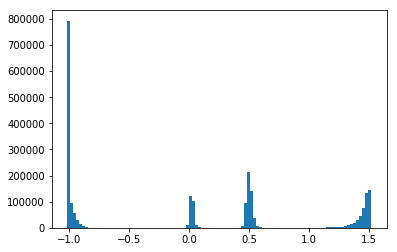

In [17]:
encoded_sample = model.project(data)
plt.hist(encoded_sample, bins=100)

In [ ]:
model.encoder.layers

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [8]:
vec_sample = np.array(rdd.sample(False, 0.01).collect())
encoded_sample = model.project(vec_sample)

# decoded_sample = data
decoded_sample = model.decode(encoded_sample)
decoded_sample.shape

(22535, 3)

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

encoded_x_sample = encoded_sample[:,0].reshape(-1,1)
dencoded_y_sample = decoded_sample[:,0].reshape(-1,1)

for i in range(2, 10):
  z_train, z_test, x_train, x_test = train_test_split(encoded_x_sample, dencoded_y_sample, test_size=0.4)
  gmm = GaussianMixture(i).fit(z_train)
  bic = gmm.bic(z_test)
  labels = gmm.predict(z_test)
  ss = silhouette_score(x_test, labels)
  print(i, bic, ss)

(2, 22860.687369517636, 0.41072610349447514)
(3, 12763.132987421812, 0.4873411057035125)
(4, 9621.984985738864, 0.6049687548656997)
(5, 9496.53577122682, 0.5700197372127715)
(6, 9048.603016026918, 0.37332278940894126)
(7, 8913.499825276993, 0.31950360789236504)
(8, 8888.716481612686, 0.2757845583639317)
(9, 8776.807228609861, 0.30912203993217174)


In [31]:
a = np.append(labels.reshape(-1,1), x_test, axis=1)

In [38]:
np.where()

(array([   0,    0,    1, ..., 9012, 9013, 9013]),
 array([0, 1, 0, ..., 1, 0, 1]))